https://www.kaggle.com/c/competitive-data-science-final-project

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [1]:
path = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/all/'

items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')
sales_train = pd.read_csv(path+'sales_train.csv')
test = pd.read_csv(path+'test.csv')

# Format 'date' to datetime
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')

# Add item_category_id to sales_train
sales_train = pd.merge(sales_train,items[['item_id','item_category_id']],on='item_id',how='left').sort_values(by='item_id')

#add new columns: years, month, Y_M
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train_year = sales_train['date'].dt.year.astype('string')
sales_train_month = sales_train['date'].dt.month.astype('string')
sales_train['Y_M'] = sales_train_year+'_'+sales_train_month

#split by year
sales_train_2013 = sales_train[sales_train['year']==2013]
sales_val_2014 = sales_train[sales_train['year']==2014]
sales_test_2015 = sales_train[sales_train['year']==2015]

In [2]:
#notes: price of the same item may vary across shops, and across time.
sales_train[(sales_train['item_id']==1495)&(sales_train.date.dt.month==11)].sort_values(by=(['shop_id','item_id'])).head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month,Y_M
1067995,2013-11-30,10,2,1495,599.0,1.0,30,2013,11,2013_11
1067994,2013-11-29,10,2,1495,599.0,1.0,30,2013,11,2013_11
1067993,2013-11-28,10,2,1495,599.0,3.0,30,2013,11,2013_11
1067991,2013-11-23,10,2,1495,699.0,1.0,30,2013,11,2013_11
1067992,2013-11-27,10,2,1495,599.0,1.0,30,2013,11,2013_11


In [3]:
#columns to keep
#col_to_keep = ['shop_id','item_id','item_price','item_category_id','item_cnt_day']
col_to_keep = ['shop_id','item_id','item_category_id','item_cnt_day']

groupby_list = ['shop_id','item_id']

#agg_dict = {'item_price':'mean','item_category_id':'mean','item_cnt_day':'sum'}
agg_dict = {'item_category_id':'mean','item_cnt_day':'sum'}
agg_targ = {'item_cnt_day':'sum'}

# training set : nov 2013 with lag features (1 month back)

In [4]:
x_train = sales_train_2013[sales_train_2013['month']==11]
x_train = x_train[col_to_keep]

#agg shop_item 
x_train_shop_item = x_train.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_train_shop = x_train[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_train_item = x_train[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
x_train_itemcat = x_train[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#merge
# x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop,on=['shop_id'],how='left')
# x_train_shop_item = pd.merge(x_train_shop_item,x_train_item,on=['item_id'],how='left')
# x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat,on=['item_category_id'],how='left')

#introduce lag features
x_train_lag_1 = sales_train_2013[sales_train_2013['month']==10]
x_train_lag_1 = x_train_lag_1[col_to_keep]

#agg shop_item 
x_train_shop_item_lag_1 = x_train_lag_1.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
x_train_shop_item_lag_1.drop(columns=['item_category_id'],inplace=True)
#agg shop 
x_train_shop_lag_1 = x_train_lag_1[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_1'})
#agg item 
x_train_item_lag_1 = x_train_lag_1[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_1'})
#agg item_cat 
x_train_itemcat_lag_1 = x_train_lag_1[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_1'})

#merge
x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_item_lag_1,on=['shop_id','item_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_lag_1,on=['shop_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_item_lag_1,on=['item_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat_lag_1,on=['item_category_id'],how='left')

y_train = x_train_shop_item['shop_item_cnt_month']
x_train = x_train_shop_item.drop(columns=['shop_item_cnt_month'])

x_train = x_train.fillna(0)
print 'x_train.shape :',x_train.shape
x_train.head()

x_train.shape : (51460, 7)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,item_cat_cnt_month_lag_1
0,2,33,37,0.0,795.0,33.0,6950.0
1,2,97,40,0.0,795.0,4.0,24173.0
2,2,482,73,1.0,795.0,132.0,607.0
3,2,791,73,2.0,795.0,62.0,607.0
4,2,944,37,0.0,795.0,40.0,6950.0


# validation set: nov 2014 with lag features (1 month back)

In [5]:
x_val = sales_val_2014[sales_val_2014['month']==11]
x_val = x_val[col_to_keep]

#agg shop_item 
x_val_shop_item = x_val.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_val_shop = x_val[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_val_item = x_val[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
x_val_itemcat = x_val[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#merge
# x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop,on=['shop_id'],how='left')
# x_val_shop_item = pd.merge(x_val_shop_item,x_val_item,on=['item_id'],how='left')
# x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat,on=['item_category_id'],how='left')

#introduce lag features
x_val_lag_1 = sales_val_2014[sales_val_2014['month']==10]
x_val_lag_1 = x_val_lag_1[col_to_keep]

#agg shop_item 
x_val_shop_item_lag_1 = x_val_lag_1.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
x_val_shop_item_lag_1.drop(columns=['item_category_id'],inplace=True)
#agg shop 
x_val_shop_lag_1 = x_val_lag_1[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_1'})
#agg item 
x_val_item_lag_1 = x_val_lag_1[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_1'})
#agg item_cat 
x_val_itemcat_lag_1 = x_val_lag_1[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_1'})

#merge
x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_item_lag_1,on=['shop_id','item_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_lag_1,on=['shop_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_item_lag_1,on=['item_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat_lag_1,on=['item_category_id'],how='left')

y_val = x_val_shop_item['shop_item_cnt_month']
x_val = x_val_shop_item.drop(columns=['shop_item_cnt_month'])

x_val = x_val.fillna(0)
print 'x_val.shape :',x_val.shape
x_val.head()

x_val.shape : (45755, 7)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,item_cat_cnt_month_lag_1
0,2,486,73,1.0,945.0,183.0,443.0
1,2,491,73,1.0,945.0,18.0,443.0
2,2,806,49,1.0,945.0,63.0,903.0
3,2,949,23,0.0,945.0,35.0,4001.0
4,2,950,19,0.0,945.0,27.0,5173.0


In [6]:
y_val.head()

0    2.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: shop_item_cnt_month, dtype: float64

# contruct test set: nov 2015 with lag features (1 month back)

In [7]:
x_test = test.sort_values(by=groupby_list)

x_test_lag_1 = sales_test_2015[sales_test_2015['month']==10]
x_test_lag_1 = x_test_lag_1[col_to_keep]

x_test_shop_item_lag_1 = x_test_lag_1.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
x_test_shop_lag_1 = x_test_lag_1[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_1'})
x_test_item_lag_1 = x_test_lag_1[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_1'})
x_test_itemcat_lag_1 = x_test_lag_1[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'itemcat_cnt_month_lag_1'})

#add item_category_id.
x_test_with_lag = pd.merge(x_test[groupby_list],items[['item_id','item_category_id']],on='item_id',how='left')
x_test_with_lag.head()

#add last months item_cnt
x_test_with_lag = pd.merge(x_test_with_lag,x_test_shop_item_lag_1[['shop_id','item_id','shop_item_cnt_month_lag_1']],on=(groupby_list),how='left')
x_test_with_lag = pd.merge(x_test_with_lag,x_test_shop_lag_1[['shop_id','shop_cnt_month_lag_1']],on=(['shop_id']),how='left')
x_test_with_lag = pd.merge(x_test_with_lag,x_test_item_lag_1[['item_id','item_cnt_month_lag_1']],on=(['item_id']),how='left')
x_test_with_lag = pd.merge(x_test_with_lag,x_test_itemcat_lag_1[['item_category_id','itemcat_cnt_month_lag_1']],on=(['item_category_id']),how='left')

x_test = x_test_with_lag.fillna(0)

print 'x_test_with_lag.shape :',x_test_with_lag.shape
x_test.head()

x_test_with_lag.shape : (214200, 7)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,itemcat_cnt_month_lag_1
0,2,30,40,0.0,727.0,1.0,7680.0
1,2,31,37,1.0,727.0,18.0,4061.0
2,2,32,40,0.0,727.0,22.0,7680.0
3,2,33,37,0.0,727.0,16.0,4061.0
4,2,38,41,0.0,727.0,0.0,309.0


# Preliminary / baseline model training

### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(x_train.values, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
pred_lr = lr.predict(x_train.values)
print('Training R-squared for linreg is %f' % r2_score(y_train, pred_lr))

Training R-squared for linreg is 0.637483


In [10]:
pred_lr = lr.predict(x_val.values)
print('Validation R-squared for linreg is %f' % r2_score(y_val, pred_lr))

Validation R-squared for linreg is 0.301402


### Boosted Decision Tree (lightgbm)

In [29]:
import lightgbm as lgb
evals_result={}

lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_test = lgb.Dataset(x_val, label=y_val)

lgb_params = {
               'feature_fraction': 1.0,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }

model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=10000,
                  evals_result=evals_result,
                  early_stopping_rounds=500,
                  verbose_eval=500)

#print 'evals_result = ',evals_result

Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 6.93853	eval's rmse: 9.17732
[1000]	train's rmse: 6.39207	eval's rmse: 8.99987
[1500]	train's rmse: 6.06932	eval's rmse: 8.9031
[2000]	train's rmse: 5.80397	eval's rmse: 8.82327
[2500]	train's rmse: 5.52781	eval's rmse: 8.73589
[3000]	train's rmse: 5.32818	eval's rmse: 8.69838
[3500]	train's rmse: 5.17314	eval's rmse: 8.65751
[4000]	train's rmse: 5.00769	eval's rmse: 8.61681
[4500]	train's rmse: 4.86058	eval's rmse: 8.58689
[5000]	train's rmse: 4.73882	eval's rmse: 8.56491
[5500]	train's rmse: 4.60463	eval's rmse: 8.55051
[6000]	train's rmse: 4.48803	eval's rmse: 8.54481
[6500]	train's rmse: 4.41979	eval's rmse: 8.53934
Early stopping, best iteration is:
[6070]	train's rmse: 4.47812	eval's rmse: 8.53679


Plot metrics recorded during training...


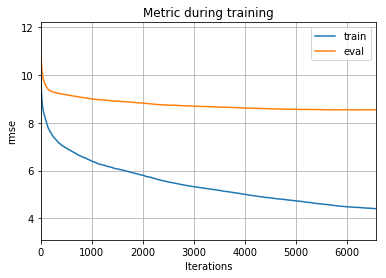

Plot feature importances...


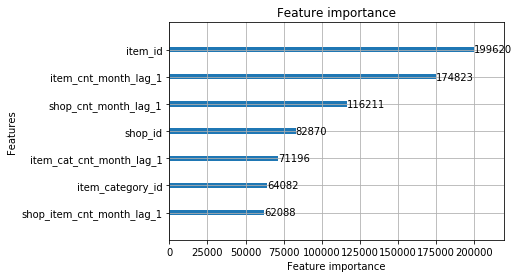

In [30]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.savefig("lgb_plot_metric.pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.savefig("lgb_plot_importance.pdf")
plt.show()

In [31]:
pred_lgb = model.predict(x_train)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Training R-squared for LightGBM is 0.797418


In [32]:
pred_lgb = model.predict(x_val)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Validation R-squared for LightGBM is 0.393671


### predict with test and prepare submission

In [33]:
pred_submit = model.predict(x_test)

In [34]:
pred_submit.size

214200

In [35]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_day'])

In [36]:
# this order is based on x_test which is test.sort_values(by=groupby_list)
y_test.head() 

,item_cnt_day
0,0.513161
1,0.842180
2,0.356268
3,0.820501
4,-14.249117


In [37]:
test.sort_values(by=groupby_list).head()

,ID,shop_id,item_id
22987,22987,2,30
20994,20994,2,31
20995,20995,2,32
22492,22492,2,33
22491,22491,2,38


In [38]:
test_sorted = test.sort_values(by=groupby_list).reset_index(drop=True)

In [39]:
test_sorted.head()

,ID,shop_id,item_id
0,22987,2,30
1,20994,2,31
2,20995,2,32
3,22492,2,33
4,22491,2,38


In [40]:
submit = pd.concat([test_sorted,y_test],axis=1)

In [41]:
submit.head()

,ID,shop_id,item_id,item_cnt_day
0,22987,2,30,0.513161
1,20994,2,31,0.842180
2,20995,2,32,0.356268
3,22492,2,33,0.820501
4,22491,2,38,-14.249117


In [42]:
submit = submit.sort_values(by="ID").reset_index(drop=True)

In [43]:
submit.head()

,ID,shop_id,item_id,item_cnt_day
0,0,5,5037,0.878411
1,1,5,5320,-0.934888
2,2,5,5233,1.032142
3,3,5,5232,1.092099
4,4,5,5268,0.799432


In [44]:
# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_day"].values[0]

These numbers below should match:
y_test.iloc[0] = 0.5131613237518983
submit[submit["ID"]==22987] =  0.5131613237518983


In [45]:
submit = submit[["ID","item_cnt_day"]]
submit.head()

,ID,item_cnt_day
0,0,0.878411
1,1,-0.934888
2,2,1.032142
3,3,1.092099
4,4,0.799432


In [4]:
submit = pd.read_csv('submit_Oct8-2018_1.csv')

In [6]:
submit = submit[['ID','item_cnt_day']]

In [10]:
submit = submit.rename(columns={'item_cnt_day':'item_cnt_month'})

In [32]:
submit = submit[['item_cnt_month']]
submit.index.name = 'ID'
submit.head()

,item_cnt_month
ID,
0,0.878411
1,-0.934888
2,1.032142
3,1.092099
4,0.799432


In [33]:
submit.to_csv('submit_Oct8-2018_2.csv')